In [1]:
import os, time
from IPython.display import Image as IImage
from tqdm import tnrange, tqdm_notebook, tqdm
import torch
import torch.nn.functional as F
from torch import nn, autograd, optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms, datasets
from torchvision.utils import save_image, make_grid
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
now = int(time.time())

In [3]:
from matplotlib import rcParams
rcParams['figure.figsize'] = (12, 8)

%matplotlib inline

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
batch_size = 64
num_epochs = 10000

z_dimension = 100

In [6]:
device_ids = [0] #, 1]

In [7]:
wh = 64
img_transform = transforms.Compose([
    transforms.Resize(wh),
    transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5), (.5, .5, .5))
])

# dataset = datasets.ImageFolder('~/data/anime-faces', transform=img_transform)
dataset = datasets.ImageFolder('~/data/faceimgs', transform=img_transform) # https://lab.grapeot.me/faceimgs.tar
# dataset = datasets.ImageFolder('~/data/af', transform=img_transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=8)

In [8]:
class SelfAttention(nn.Module):
    """ Self attention Layer"""
    def __init__(self, in_dim):
        super(SelfAttention,self).__init__()
        
        self.query_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim // 8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim // 8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

        self.softmax  = nn.Softmax(dim=-1) #
        
    def forward(self, x):
        
        m_batchsize, C, width ,height = x.size()
        proj_query = self.query_conv(x).view(m_batchsize, -1, width * height).permute(0, 2, 1) # B (N) C
        proj_key = self.key_conv(x).view(m_batchsize, -1, width * height) # B C (N)
        energy = torch.bmm(proj_query, proj_key) # transpose check
        attention = self.softmax(energy) # B (N) (N) 
        proj_value = self.value_conv(x).view(m_batchsize, -1, width * height) # B C N

        out = torch.bmm(proj_value, attention.permute(0, 2, 1)) # B C N
        out = out.view(m_batchsize, C, width, height) # B C W H
        
        out = self.gamma * out + x
        return out, attention

In [9]:
def calc_gradient_penalty(netD, real_data, fake_data):
    alpha = torch.rand(1, 1, 1, 1)
    alpha = alpha.expand_as(real_data)
    alpha = alpha.to(device)
    
    interpolates = alpha * real_data.detach() + ((1 - alpha) * fake_data.detach())

    interpolates = interpolates.to(device)
    interpolates.requires_grad_(True)

    disc_interpolates = netD(interpolates)

    gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones(disc_interpolates.size()).to(device),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]

    gradients = gradients.view(gradients.size(0), -1)                              
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * 10
    return gradient_penalty

In [10]:
def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

In [11]:
class Upscale2d(nn.Module):
    def __init__(self, factor=2, gain=1):
        """
            the first upsample method in G_synthesis.
        :param factor:
        :param gain:
        """
        super().__init__()
        self.gain = gain
        self.factor = factor

    def forward(self, x):
        if self.gain != 1:
            x = x * self.gain
        if self.factor > 1:
            shape = x.shape
            x = x.view(shape[0], shape[1], shape[2], 1, shape[3], 1).expand(-1, -1, -1, self.factor, -1, self.factor)
            x = x.contiguous().view(shape[0], shape[1], self.factor * shape[2], self.factor * shape[3])
        return x

In [12]:
class PixelNorm(nn.Module):
    def __init__(self, epsilon=1e-8):
        """
            @notice: avoid in-place ops.
            https://discuss.pytorch.org/t/encounter-the-runtimeerror-one-of-the-variables-needed-for-gradient-computation-has-been-modified-by-an-inplace-operation/836/3
        """
        super(PixelNorm, self).__init__()
        self.epsilon = epsilon

    def forward(self, x):
        tmp  = torch.mul(x, x) # or x ** 2
        tmp1 = torch.rsqrt(torch.mean(tmp, dim=1, keepdim=True) + self.epsilon)

        return x * tmp1

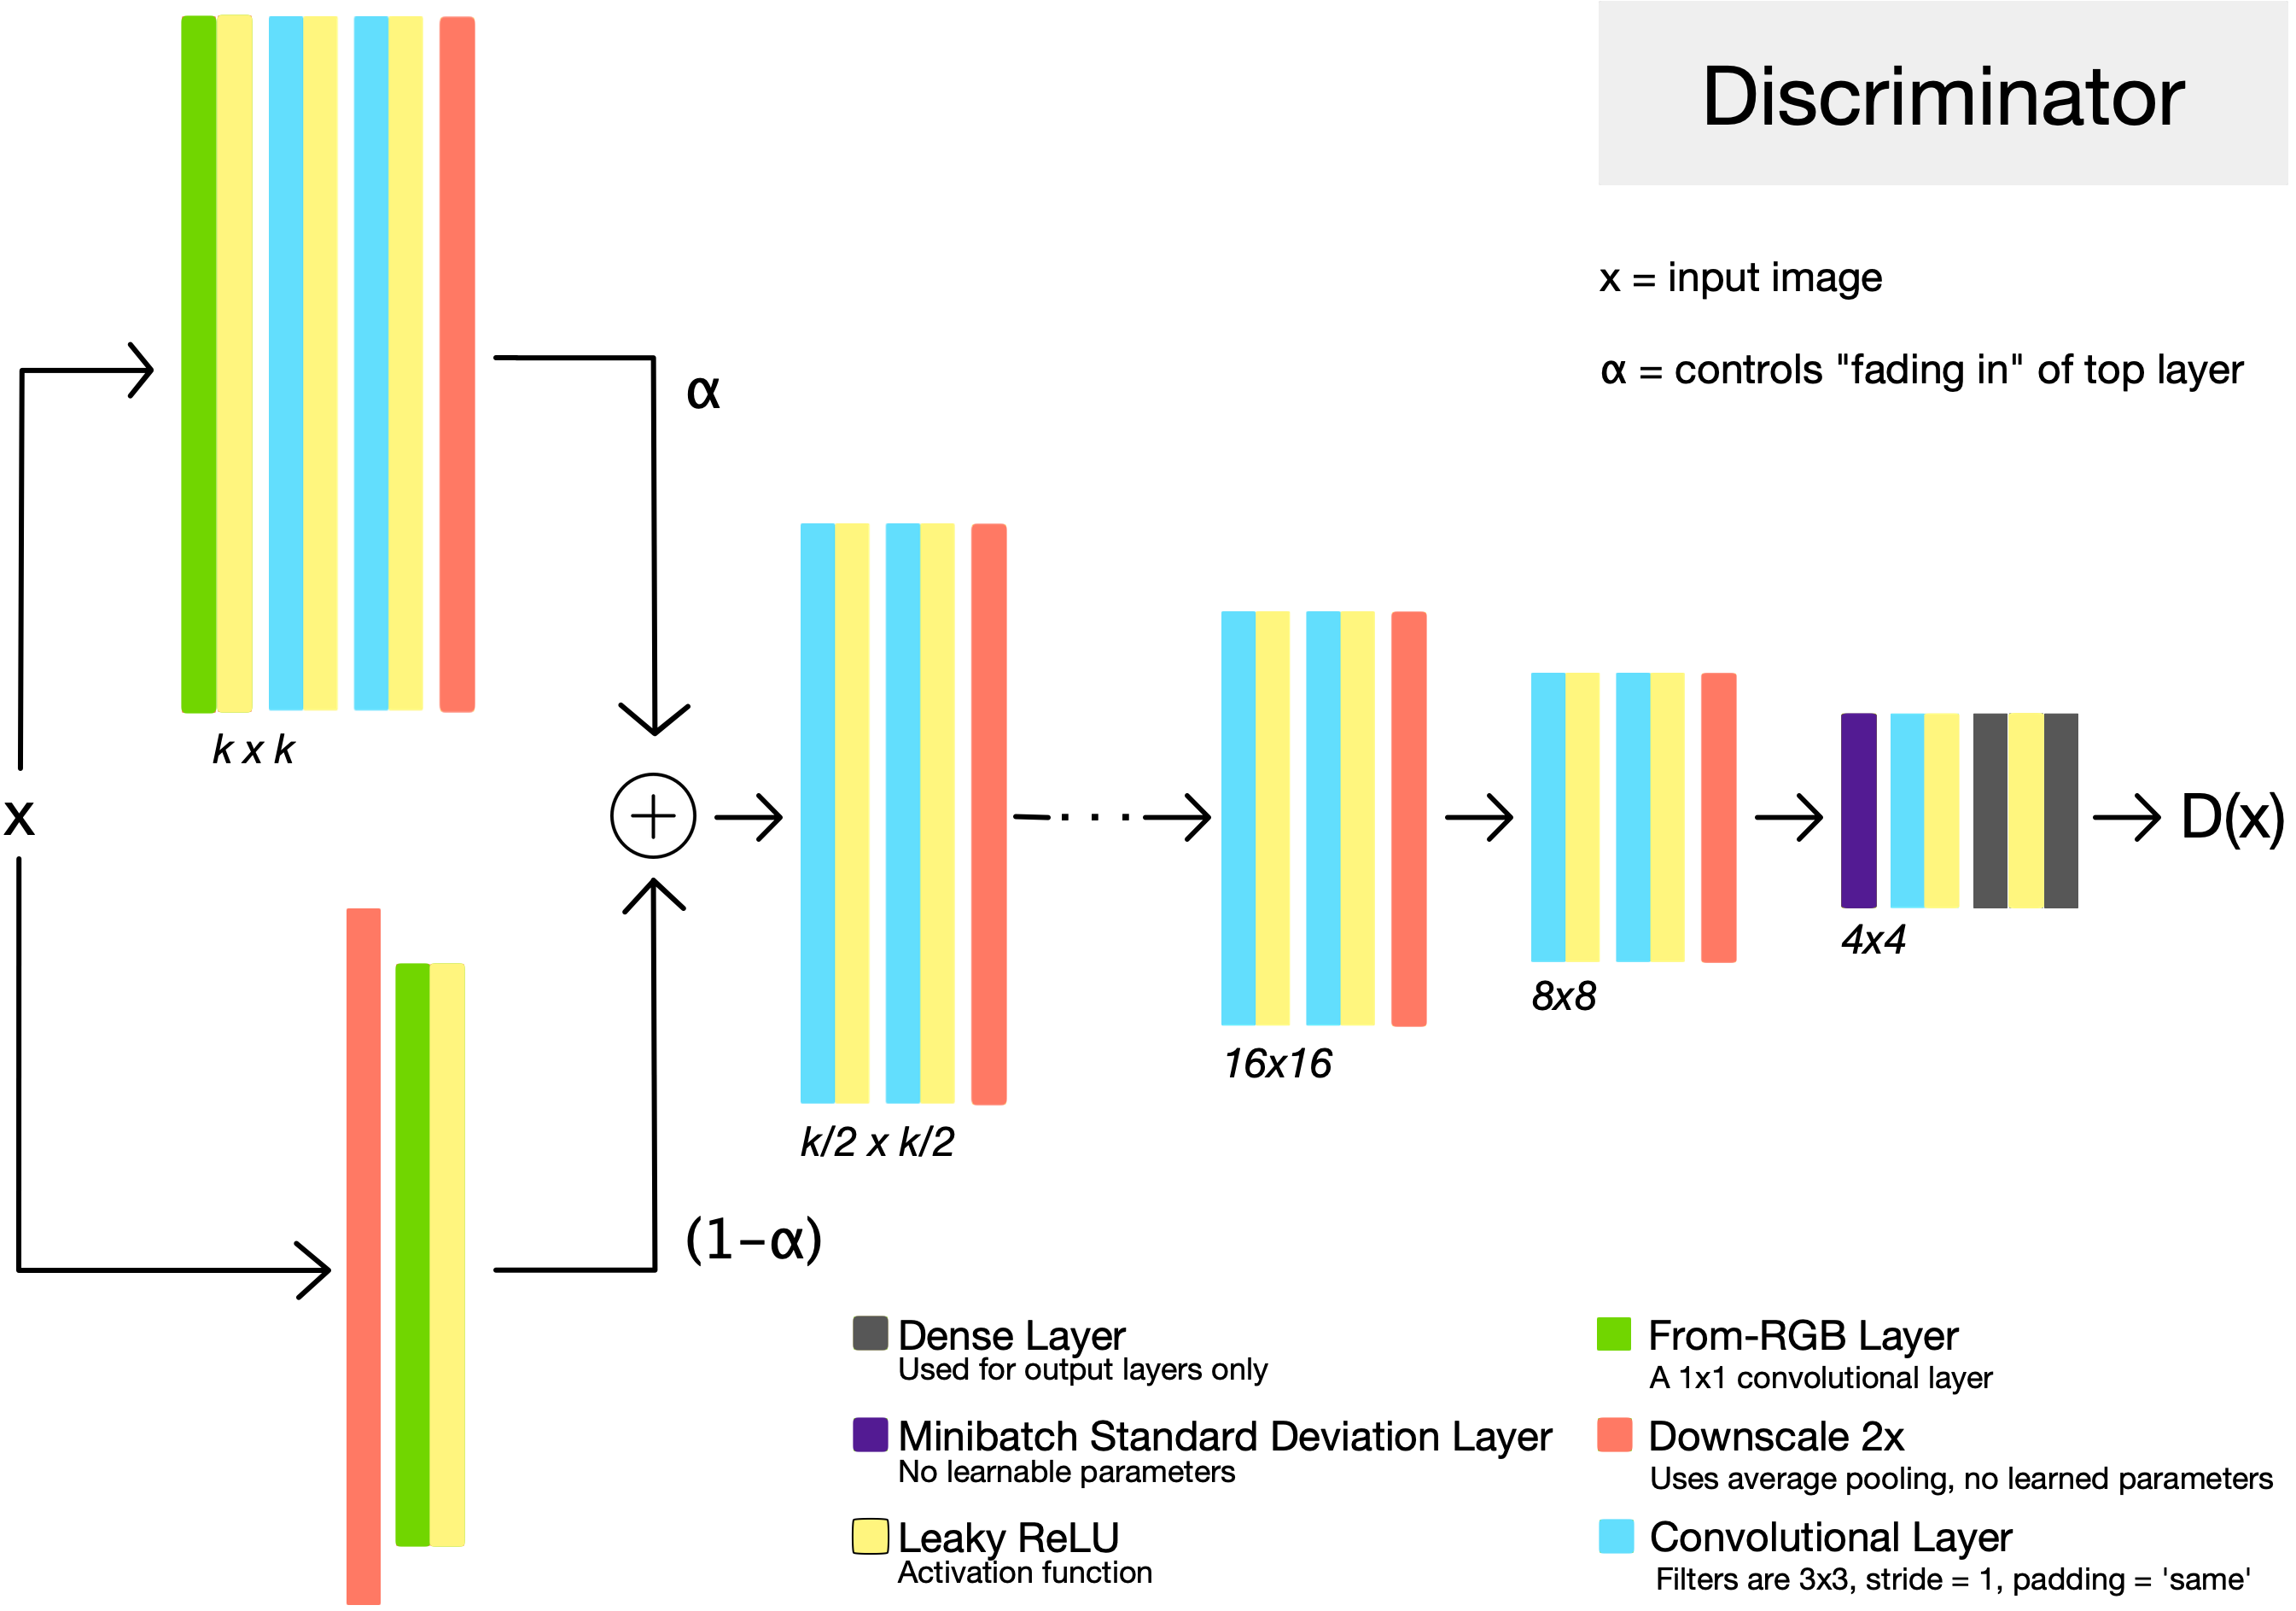

In [13]:
IImage('progan/discriminator.png', width=500)

In [14]:
class Discriminator(nn.Module): # b 3 64 64
    def __init__(self, d=64):
        super(Discriminator, self).__init__()
        
#         self.alpha = torch.nn.Parameter(torch.rand([1]))
#         self.nalpha = torch.Tensor(1) - self.alpha
        self.alpha = torch.nn.Parameter(torch.Tensor([.5]))
        self.one = torch.FloatTensor([1]).to(device)
        self.input1 = nn.Sequential(
            nn.Conv2d(3, d, 1, 1),
            nn.LeakyReLU(.2, True),
            nn.Conv2d(d, d, 3, 1, 1),
            nn.LeakyReLU(.2, True),
            nn.Conv2d(d, d, 4, 2, 1),
#             nn.BatchNorm2d(d),
        ) # b 3 32 32
        
        self.input2 = nn.Sequential(
            nn.Conv2d(3, d, 4, 2, 1),
            nn.Conv2d(d, d, 1, 1),
#             nn.BatchNorm2d(d),
            nn.LeakyReLU(.2, True),
        ) # b 3 32 32
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(d, d, 3, 1, 1),
            nn.LeakyReLU(.2, True),
            nn.Conv2d(d, d, 3, 1, 1),
            nn.LeakyReLU(.2, True),
            nn.Conv2d(d, d*2, 4, 2, 1),
#             nn.BatchNorm2d(d*2),
            nn.LeakyReLU(.2, True),
        ) # b d 16 16
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(d*2, d*2, 3, 1, 1),
            nn.LeakyReLU(.2, True),
            nn.Conv2d(d*2, d*2, 3, 1, 1),
            nn.LeakyReLU(.2, True),
            nn.Conv2d(d*2, d*4, 4, 2, 1),
#             nn.BatchNorm2d(d*4),
            nn.LeakyReLU(.2, True),
        ) # b d*2 8 8
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(d*4, d*4, 3, 1, 1),
            nn.LeakyReLU(.2, True),
            nn.Conv2d(d*4, d*4, 3, 1, 1),
            nn.LeakyReLU(.2, True),
            nn.Conv2d(d*4, d*8, 4, 2, 1),
#             nn.BatchNorm2d(d*8),
            nn.LeakyReLU(.2, True),
        ) # b d*8 4 4
        
        self.output1 = nn.Sequential(
            nn.BatchNorm2d(d*8),
            nn.Conv2d(d*8, d, 3, 1, 1),
            nn.LeakyReLU(.2, True),
        ) # b d 4 4
    
        self.output2 = nn.Sequential(
            nn.Linear(d * 16, 32),
            nn.LeakyReLU(.2, True),
            nn.Linear(32, 1),
            nn.Sigmoid(),
        ) # b 1 1 1
        
        
        
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)
    
    def forward(self, x): # b 3 w h
        
        input1 = self.input1(x)
        input2 = self.input2(x)
        
        out = self.conv2(torch.add(torch.mul(input1, self.alpha), torch.mul(input2, torch.sub(self.one, self.alpha))))
        out = self.conv3(out)
        out = self.conv4(out)
        
        out = self.output1(out)
        return self.output2(out.view(x.size(0), -1)).view(x.size(0), -1)

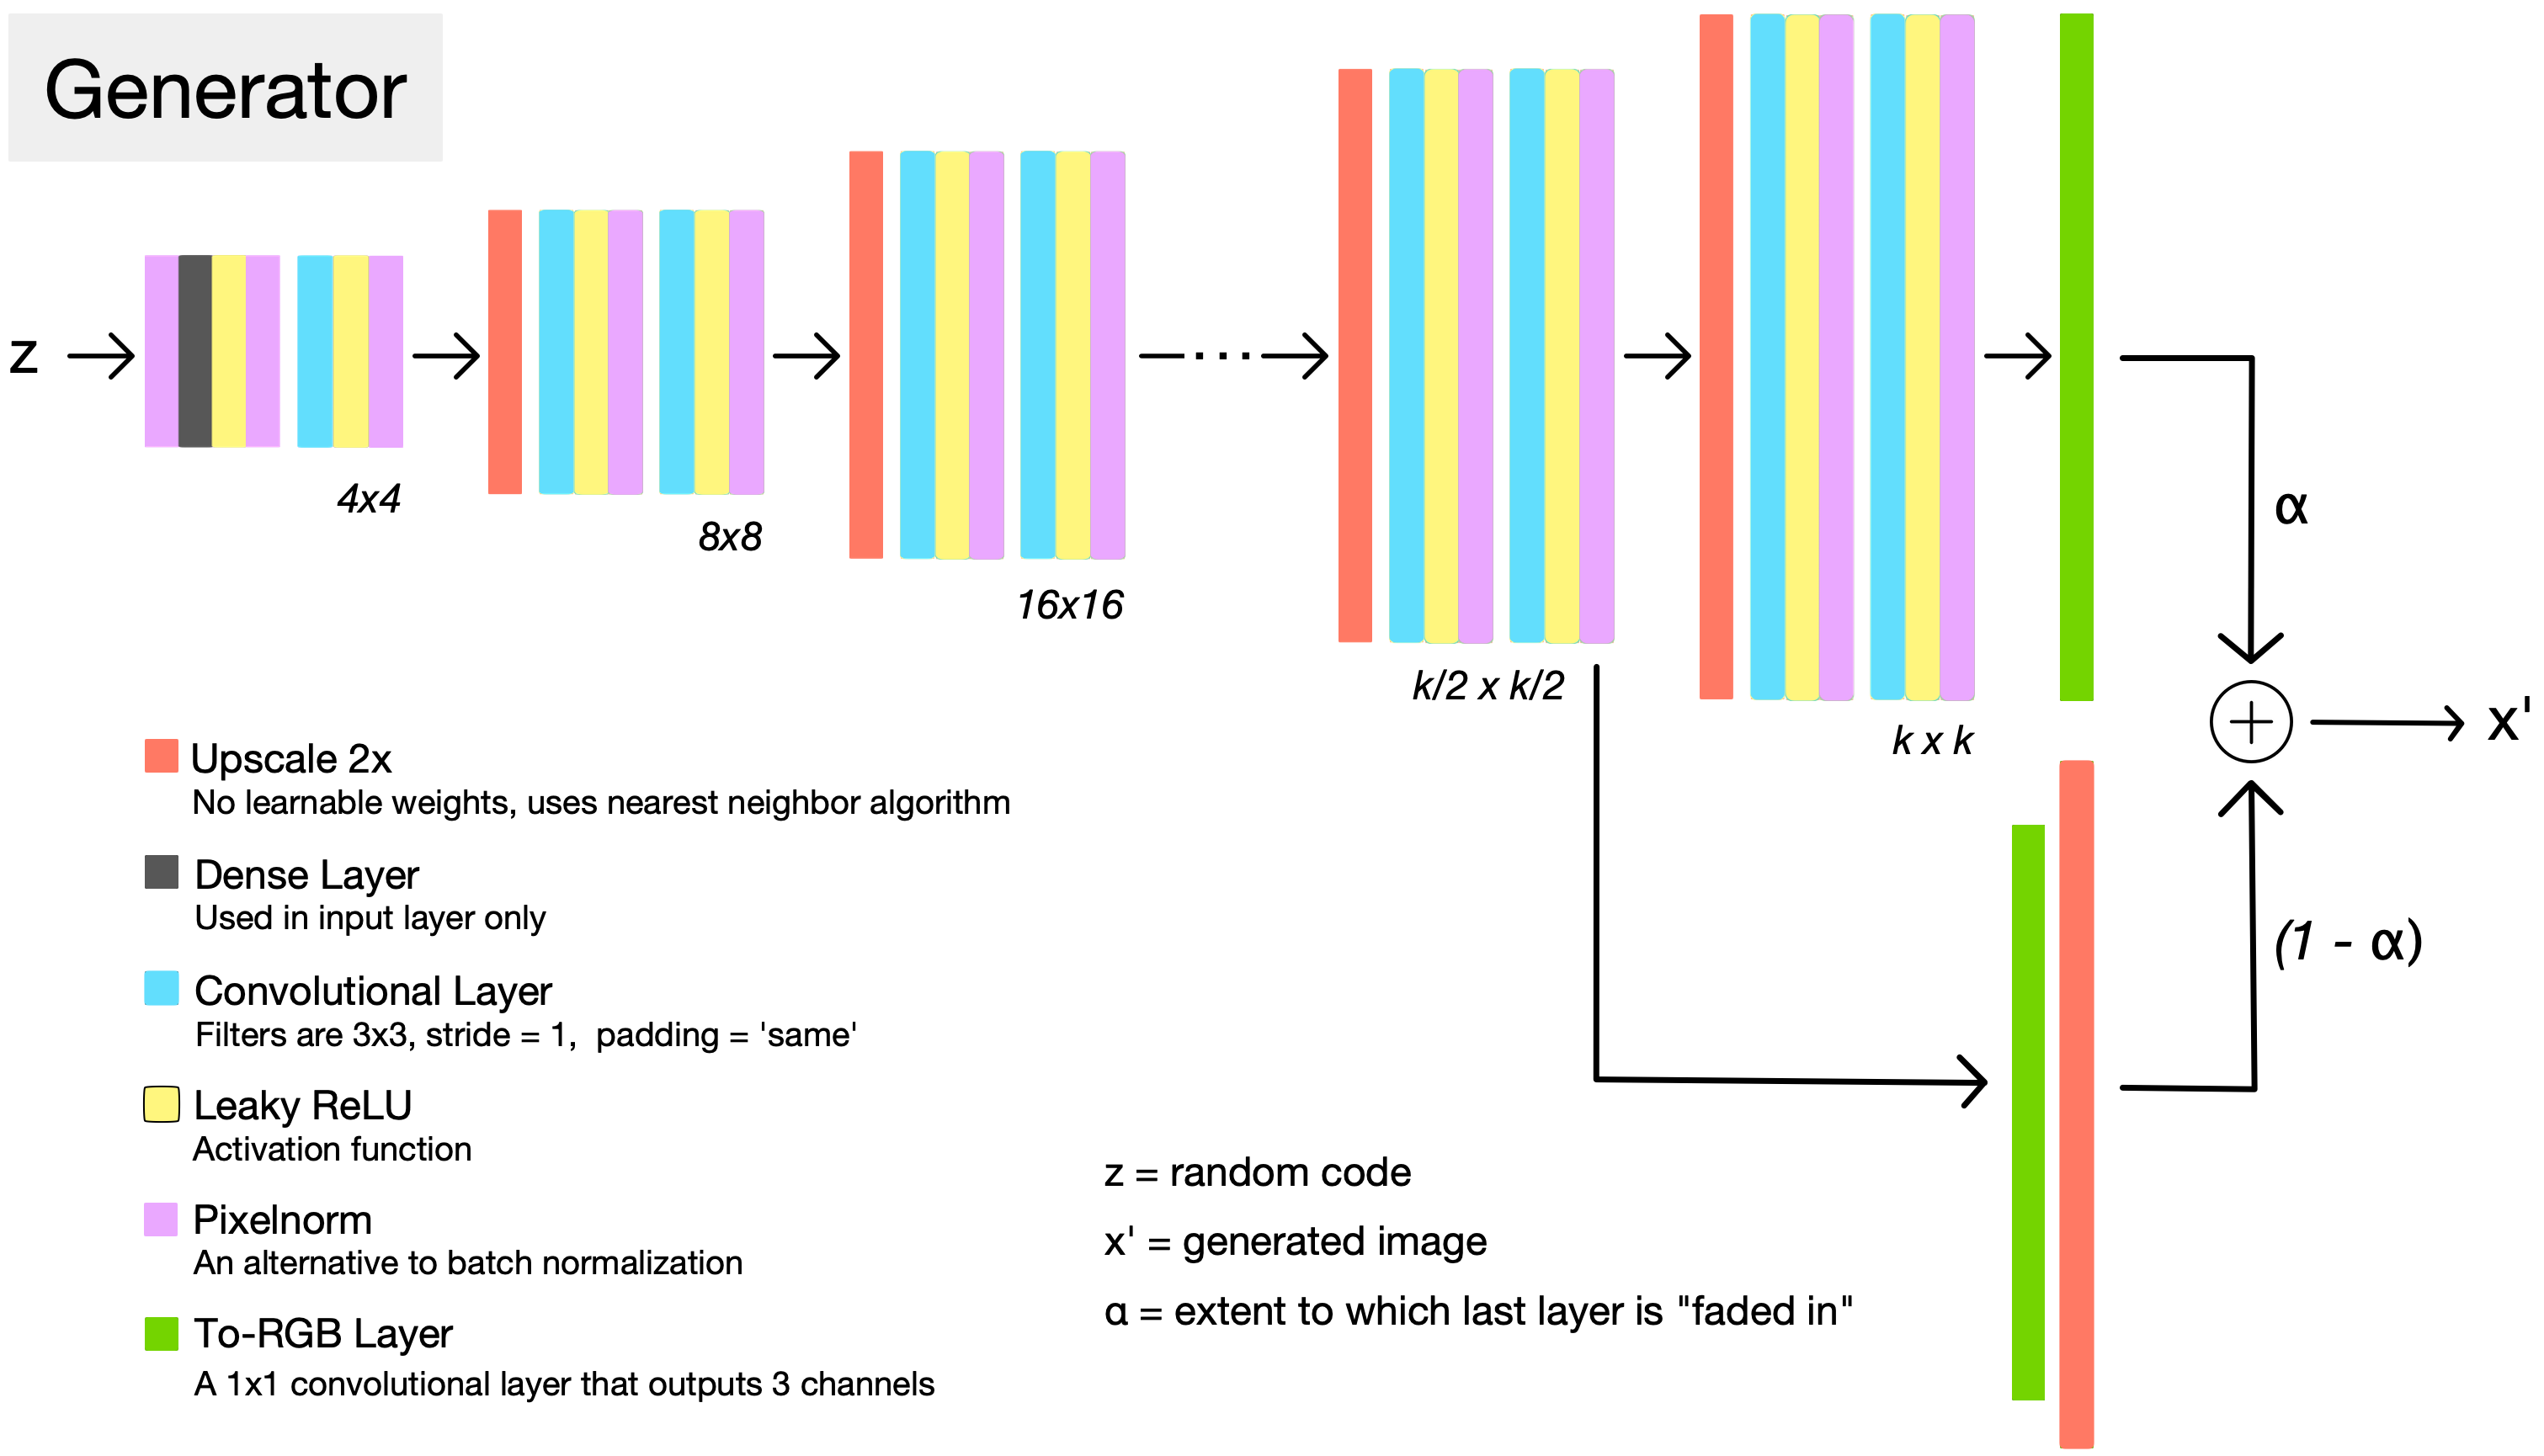

In [15]:
IImage(filename='progan/generator.png', width=500)

In [16]:
class Generator(nn.Module):
    def __init__(self, inp_dim, d=64):
        super(Generator, self).__init__()
        
#         self.upsample1_1 = nn.Sequential(
#             PixelNorm(),
#         )
        
        self.upsample1_2 = nn.Sequential(
            nn.Linear(inp_dim, d*8)
        )
        
        self.upsample1_3 = nn.Sequential(
            nn.LeakyReLU(.2, True),
#             PixelNorm(),
            nn.Conv2d(32, d*8, 3, 1, 1),
#             nn.BatchNorm2d(d*8),
            nn.LeakyReLU(.2, True),
            PixelNorm(),
        ) # b 512 4 4
        
        self.deconv3 = nn.Sequential(
            nn.ConvTranspose2d(d*8, d*4, 4, 2, 1),
            nn.Conv2d(d*4, d*4, 3, 1, 1),
#             nn.BatchNorm2d(d*4),
            nn.LeakyReLU(.2, True),
            PixelNorm(),
        ) # b d*4 8 8
        
        self.deconv4 = nn.Sequential(
            nn.ConvTranspose2d(d*4, d*2, 4, 2, 1),
            nn.Conv2d(d*2, d*2, 3, 1, 1),
#             nn.BatchNorm2d(d*2),
            nn.LeakyReLU(.2, True),
            PixelNorm(),
        ) # b d*2 16 16
        
        self.deconv5 = nn.Sequential(
            nn.ConvTranspose2d(d*2, d, 4, 2, 1),
            nn.Conv2d(d, d, 3, 1, 1),
#             nn.BatchNorm2d(d),
            nn.LeakyReLU(.2, True),
            PixelNorm(),
        ) # b d 32 32
        
#         self.alpha = torch.nn.Parameter(torch.rand(1))
#         self.nalpha = 1 - self.alpha
        self.alpha = torch.nn.Parameter(torch.Tensor([.5]))
        self.one = torch.FloatTensor([1]).to(device)
        ##################################
        self.output1 = nn.Sequential(
            nn.ConvTranspose2d(d, 2, 4, 2, 1),
            nn.LeakyReLU(.2, True),
            nn.Conv2d(2, 3, 1, 1),
#             nn.Tanh(),
        ) # b 3 64 64
        
        self.output2 = nn.Sequential(
            nn.Conv2d(d, d, 1, 1),
            nn.ConvTranspose2d(d, 3, 4, 2, 1),
#             nn.Tanh(),
        ) # b 3 64 64
        
        
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)
            
    def forward(self, x):
        
#         out = self.upsample1_1(x)
        out = self.upsample1_2(x.view(x.size(0), -1))
        out = self.upsample1_3(out.view(x.size(0), 32, 4, 4))
        
        out = self.deconv3(out)
        out = self.deconv4(out)
        out = self.deconv5(out)
        
        out1 = self.output1(out)
        out2 = self.output2(out)

        return torch.tanh(torch.add(torch.mul(out1, self.alpha), torch.mul(out2, torch.sub(self.one, self.alpha))))

In [17]:
d = Discriminator(d=64).cuda(device_ids[0])
g = Generator(z_dimension, d=64).cuda(device_ids[0])

# d.weight_init(0.0, 0.02)
# g.weight_init(0.0, 0.02)

# d = nn.DataParallel(d, device_ids=device_ids).to(device)
# g = nn.DataParallel(g, device_ids=device_ids).to(device)

criterion = nn.BCELoss()

d_optimezer = optim.Adam(d.parameters(), lr=1e-4) # 2e-4
# d_optimezer = nn.DataParallel(d_optimezer, device_ids=device_ids)
g_optimezer = optim.Adam(g.parameters(), lr=1e-4) # 2e-4
# g_optimezer = nn.DataParallel(g_optimezer, device_ids=device_ids)

# one = torch.FloatTensor([1])
# mone = one * -1
# one = one.to(device)
# mone = mone.to(device)

In [18]:
writer = SummaryWriter(os.path.join('./runs/x_cnn_gan_faces_progan', str(now)))

In [19]:
img_path = os.path.join("save_images/x_cnn_gan_faces_progan", str(now))
if not os.path.exists(img_path): os.makedirs(img_path)

In [20]:
i = torch.randn(1, 3, 64, 64).cuda()
z = torch.randn(1, z_dimension, 1, 1).cuda()
with SummaryWriter(os.path.join('./runs/x_cnn_gan_faces_progan', str(now), 'd')) as w:
    w.add_graph(d, i)

with SummaryWriter(os.path.join('./runs/x_cnn_gan_faces_progan', str(now), 'g')) as w:
    w.add_graph(g, z)
del i, z

In [21]:
# writer.add_histogram?

In [ ]:
total_count = len(dataloader)
for epoch in tqdm_notebook(range(num_epochs)):
    
    d_loss_total = .0
    g_loss_total = .0
    _step = epoch * total_count
    for i, (img, _) in enumerate(dataloader):
        
        real_img = img.cuda()
        z = torch.randn(img.size(0), z_dimension, 1, 1).cuda()
        
        real_labels = torch.from_numpy(np.random.normal(.95, .02, [img.size(0), 1])).float().to(device)
        fake_labels = torch.from_numpy(np.random.normal(.05, .02, [img.size(0), 1])).float().to(device)
        
        
        ################### G ###################
        for p in d.parameters():
            p.requires_grad_(False)
        fake_img = g(z)
        fake_out = d(fake_img)
        
        g_loss = -fake_out.mean()
        
        g_optimezer.zero_grad()
        g_loss.backward()
        g_optimezer.step()
        #########################################
        
        
        ################### D ###################
        for p in d.parameters():
            p.requires_grad_(True)
        real_out = d(real_img)
        d_loss_real = real_out.mean()
#         real_scores = real_out
        
        fake_out = d(fake_img.detach())
        d_loss_fake = fake_out.mean()
#         fake_scores = fake_out
        
        gradient_penalty = calc_gradient_penalty(d, real_img, fake_img)
        
        d_loss = d_loss_fake - d_loss_real + gradient_penalty
        d_optimezer.zero_grad()
        d_loss.backward()
        d_optimezer.step()
        #########################################

        w_dist = d_loss_fake - d_loss_real
        
        d_loss_total += d_loss.item() * img.size(0)
        g_loss_total += g_loss.item() * img.size(0)
        
        step = _step + i + 1
        
        if (i + 1) % 200 == 0:
            writer.add_scalar('Discriminator/Real Loss', d_loss_real.item(), step)
            writer.add_scalar('Discriminator/Fake Loss', d_loss_fake.item(), step)
            writer.add_scalar('Discriminator/Loss', d_loss.item(), step)
            writer.add_scalar('Generator/Loss', g_loss.item(), step)
            
            for tag, parm in d.named_parameters():
                writer.add_histogram('Discriminator_grad/%s' % tag, parm.grad.data, step)
                writer.add_histogram('Discriminator_weight/%s' % tag, parm.data, step)
            
            for tag, parm in g.named_parameters():
                writer.add_histogram('Generator_grad/%s' % tag, parm.grad.data, step)
                writer.add_histogram('Generator_weight/%s' % tag, parm.data, step)
        
        
#         if (i + 1) % 500 == 0:
            tqdm.write('Epoch [{}/{}], Step: {:6d}, d_loss: {:.6f}, g_loss: {:.6f}, real_scores: {:.6f}' \
', fake_scores: {:.6f}, W: {:.6f}'.format(epoch+1, num_epochs, (i+1) * batch_size, d_loss, g_loss, d_loss_real.item(), d_loss_fake.item(), w_dist))
        
        if (i + 1) % 300 == 0:
            fake_images = fake_img.view(-1, 3, wh, wh)[:8].cpu().data
            save_image(fake_images, os.path.join(img_path, 'fake_images_{:04d}_{:06d}.png'.format(epoch + 1, i + 1)))

        
    _d_loss_total = d_loss_total / (total_count * (epoch + 1))
    _g_loss_total = g_loss_total / (total_count * (epoch + 1))
    
    setp = (epoch + 1) * total_count
    writer.add_scalar('Discriminator/Total Loss', _d_loss_total, step)
    writer.add_scalar('Generator/Total Loss', _g_loss_total, step)
    tqdm.write("Finish Epoch [{}/{}], Mean D Loss: {:.6f}, Mean G Loss: {:.6f}".format(epoch+1, 
                                                                             num_epochs, 
                                                                             _d_loss_total,
                                                                             _g_loss_total, ))
    if epoch == 0:
        real_images = real_img.view(-1, 3, wh, wh).cpu().data
        save_image(real_images, os.path.join(img_path, 'real_images.png'))

    fake_images = fake_img.view(-1, 3, wh, wh).cpu().data
    save_image(fake_images, os.path.join(img_path, 'fake_images-{:03d}.png'.format(epoch + 1)))

Epoch [1/10000], Step:  12800, d_loss: 8.681182, g_loss: -0.374110, real_scores: 0.201115, fake_scores: 0.374110, W: 0.172995
Epoch [1/10000], Step:  25600, d_loss: 10.428325, g_loss: -0.999938, real_scores: 0.125642, fake_scores: 0.999938, W: 0.874296
Epoch [1/10000], Step:  38400, d_loss: 8.002786, g_loss: -0.998821, real_scores: 0.113931, fake_scores: 0.998821, W: 0.884891
Epoch [1/10000], Step:  51200, d_loss: 9.609469, g_loss: -0.999928, real_scores: 0.073067, fake_scores: 0.999928, W: 0.926862
Epoch [1/10000], Step:  64000, d_loss: 9.479117, g_loss: -0.999988, real_scores: 0.054092, fake_scores: 0.999988, W: 0.945897


In [20]:
writer.close()

In [21]:
torch.save(d.state_dict(), './ser/cnn_wgan_gp_faces_discriminator_%s.pt' % str(now))
torch.save(g.state_dict(), './ser/cnn_wgan_gp_faces_generator_%s.pt' % str(now))

In [22]:
d.load_state_dict(torch.load('./ser/cnn_wgan_gp_faces_discriminator_1574063358.pt'))
g.load_state_dict(torch.load('./ser/cnn_wgan_gp_faces_generator_1574063358.pt'))

RuntimeError: Error(s) in loading state_dict for DataParallel:
	Missing key(s) in state_dict: "module.output.0.weight". 
	Unexpected key(s) in state_dict: "module.output.0.weight_orig", "module.output.0.weight_u", "module.output.0.weight_v". 

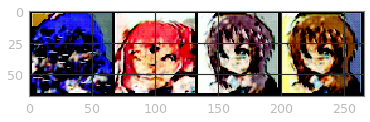

In [28]:
z = torch.randn(4, z_dimension, 1, 1).to(device)
images = g(z)
# save_image(images, 'xx.png')
plt.imshow(Image.fromarray(make_grid(images).mul(255).clamp(0, 255).byte().permute(1, 2, 0).cpu().numpy()))
plt.show()

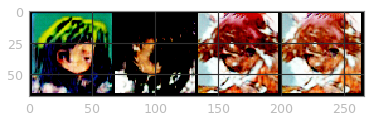

In [21]:
z = torch.randn(4, z_dimension, 1, 1).to(device)
images = g(z)
# save_image(images, 'xx.png')
plt.imshow(Image.fromarray(make_grid(images).mul(255).clamp(0, 255).byte().permute(1, 2, 0).cpu().numpy()))
plt.show()

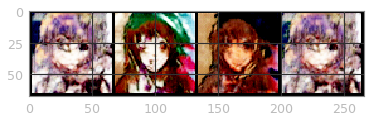

In [19]:
z = torch.randn(4, z_dimension, 1, 1).to(device)
images = g(z)
# save_image(images, 'xx.png')
plt.imshow(Image.fromarray(make_grid(images).mul(255).clamp(0, 255).byte().permute(1, 2, 0).cpu().numpy()))
plt.show()

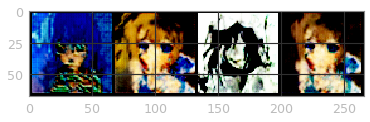

In [20]:
z = torch.randn(4, z_dimension, 1, 1).to(device)
images = g(z)
# save_image(images, 'xx.png')
plt.imshow(Image.fromarray(make_grid(images).mul(255).clamp(0, 255).byte().permute(1, 2, 0).cpu().numpy()))
plt.show()

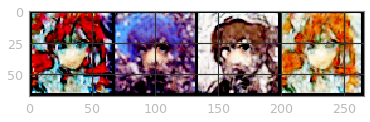

In [26]:
z = torch.randn(4, z_dimension, 1, 1).to(device)
images = g(z)
# save_image(images, 'xx.png')
plt.imshow(Image.fromarray(make_grid(images).mul(255).clamp(0, 255).byte().permute(1, 2, 0).cpu().numpy()))
plt.show()